# Data Import

In [ ]:
!git clone https://github.com/matthewljk/DR_DemandForecast.git

Cloning into 'DR_DemandForecast'...
remote: Enumerating objects: 99, done.
remote: Counting objects: 100% (99/99), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 99 (delta 35), reused 77 (delta 19), pack-reused 0
Receiving objects: 100% (99/99), 18.58 MiB | 10.97 MiB/s, done.
Resolving deltas: 100% (35/35), done.


In [ ]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Load your sequential data of electricity demand
# Assuming your data is in a CSV file, with 'demand' column representing the electricity demand
data = pd.read_csv("./DR_DemandForecast/data/NET.csv")
data['Target'] = data['Net Demand']
data

,Date,Period,Total Demand,TCQ,Net Demand,Target
0,2023-07-01,1,6119.563,486.146668,5633.416332,5633.416332
1,2023-07-01,2,6019.671,486.146668,5533.524332,5533.524332
2,2023-07-01,3,5910.691,486.146668,5424.544332,5424.544332
3,2023-07-01,4,5843.399,486.146668,5357.252332,5357.252332
4,2023-07-01,5,5797.707,486.146668,5311.560332,5311.560332
...,...,...,...,...,...,...
12892,2024-03-25,29,6979.539,355.818726,6623.720274,6623.720274
12893,2024-03-25,30,7042.605,355.818726,6686.786274,6686.786274
12894,2024-03-25,31,7067.406,355.818726,6711.587274,6711.587274
12895,2024-03-25,32,7121.950,355.818726,6766.131274,6766.131274


# Exploratory Data Analysis

## 1. Data distribution and summary

Net demand distribution

In [ ]:
data['Target'].describe()

count    12897.000000
mean      5918.388377
std        553.455214
min       4689.052462
25%       5415.945392
50%       5951.263274
75%       6430.627237
max       7000.195237
Name: Target, dtype: float64

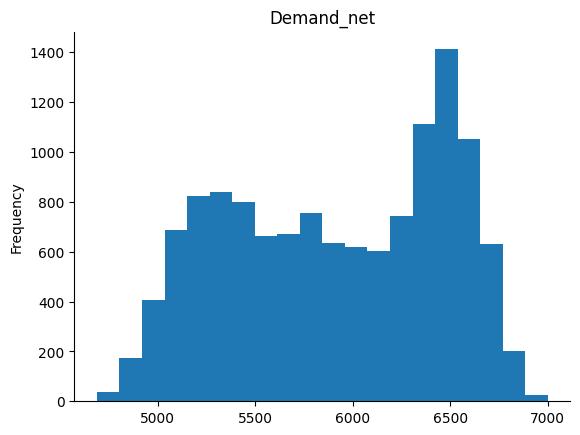

In [ ]:
import matplotlib
from matplotlib import pyplot as plt
data['Target'].plot(kind='hist', bins=20, title='Demand_net')
plt.gca().spines[['top', 'right',]].set_visible(False)

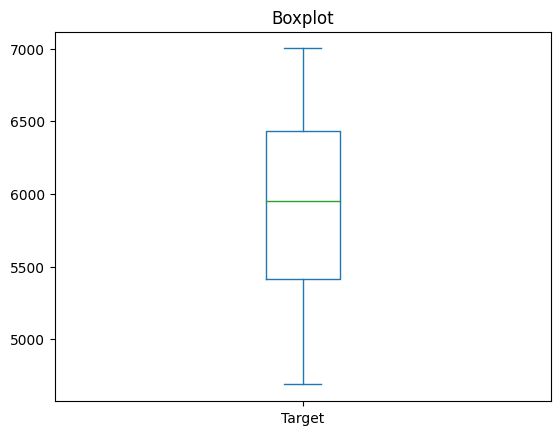

In [ ]:
data['Target'].plot.box(title='Boxplot');

Distribution of Net Demand and period

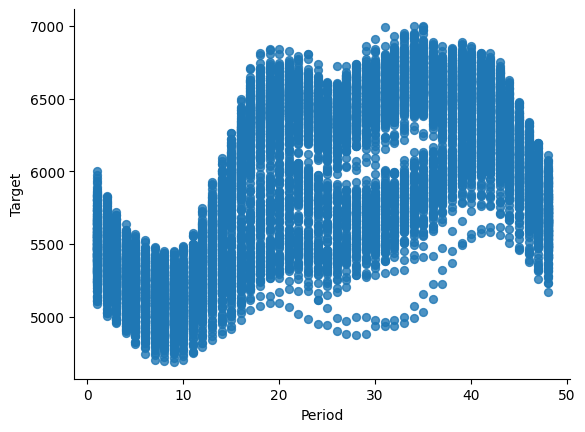

In [ ]:
data.plot(kind='scatter', x='Period', y='Target', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

Total time series

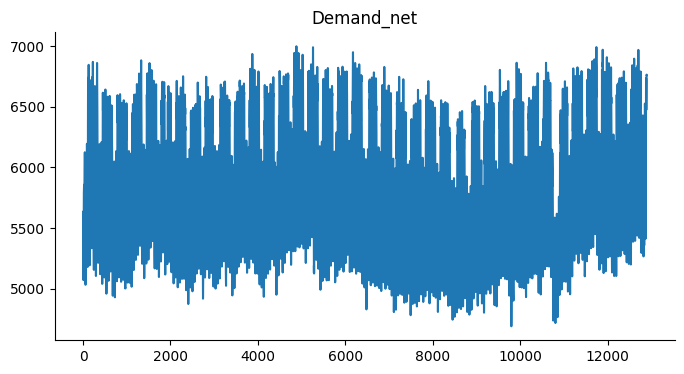

In [ ]:
data['Target'].plot(kind='line', figsize=(8, 4), title='Demand_net')
plt.gca().spines[['top', 'right']].set_visible(False)

## 2. Auto-correlation Check

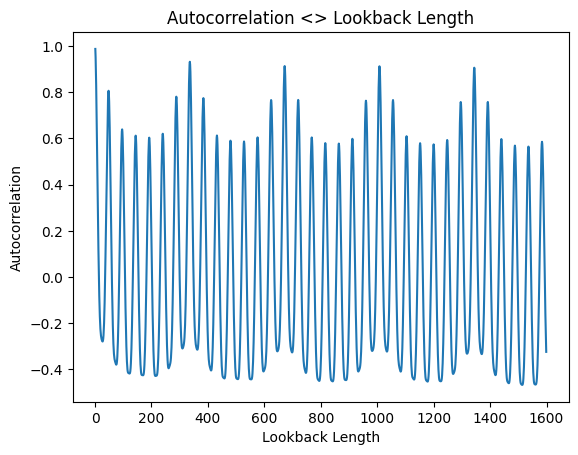

Best Lookback Length: 336


In [ ]:
# Calculate autocorrelation for different lookback lengths
lookback_lengths = range(1, 1600)
autocorrelation_values = []
for lookback in lookback_lengths:
  autocorrelation = data['Target'].autocorr(lag=lookback)
  autocorrelation_values.append(autocorrelation)

# Plot autocorrelation values
plt.plot(lookback_lengths, autocorrelation_values)
plt.xlabel('Lookback Length')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation <> Lookback Length')
plt.show()

# Sort the autocorrelation values in descending order
sorted_autocorrelation_values = sorted(autocorrelation_values, reverse=True)

best_lookback_length = max([lookback for lookback in lookback_lengths if lookback > 10], key=lambda x: autocorrelation_values[x-1])
print('Best Lookback Length:', best_lookback_length)


## 3. Staionry Test

Augmented Dickey-Fuller test:

Null Hypothesis (H0): If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.

Alternate Hypothesis (H1): The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.

In [ ]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(data['Target'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.926941
p-value: 0.000031
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

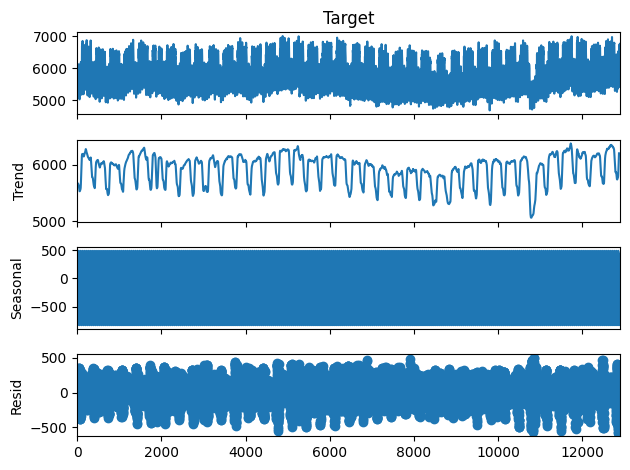

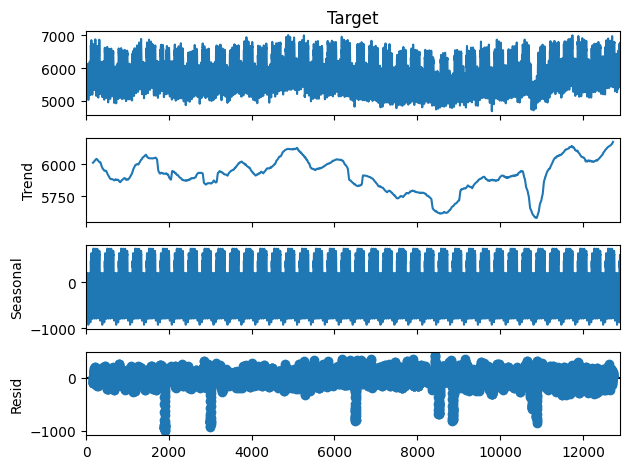

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

result1 = seasonal_decompose(data['Target'], model='additive', period=48)
result2 = seasonal_decompose(data['Target'], model='additive', period=336)
result1.plot()
result2.plot()
plt.show()

First Image (48 Periods)
In the first image, if the seasonal decomposition is calculated with a period of 1, this likely means that seasonality is being assessed at a granularity that does not correspond to any expected seasonal cycle (e.g., daily, weekly). Given there are 48 half-hour periods in a day, a period=48 might be more appropriate to capture daily seasonality. The components are:

Trend: This captures changes over the series that are more gradual. In this decomposition, the trend appears relatively flat, which suggests that over the periods shown, there isn't a clear increasing or decreasing trend in the data.

Seasonal: This is essentially a flat line, which indicates that the model did not detect any seasonality given the period of 1. This is not surprising since the chosen period does not align with any natural seasonality in the data.

Residual: The residuals appear to be the bulk of the data, showing that without a proper seasonal and trend component being extracted, most of the data is left unexplained, coming out as noise or irregular fluctuations.

Second Image (336 Periods)
In the second image, if the seasonal decomposition is calculated with a period that's suggested to be 336, this would imply that the seasonal cycle is expected to be weekly (336 half-hour periods equate to 7 days). The components are:

Trend: The trend component shows more variation over time compared to the first image, suggesting that when accounting for weekly cycles, there is a noticeable trend within each week.

Seasonal: The seasonality component has a clear pattern, likely capturing the weekly cycle. This repeating pattern every 336 periods indicates a strong weekly seasonality in the data.

Residual: The residuals in this decomposition are less chaotic than in the first image, suggesting that much of the variability in the data can be explained by the trend and weekly seasonality.

## 4. Distribution Check for scailing

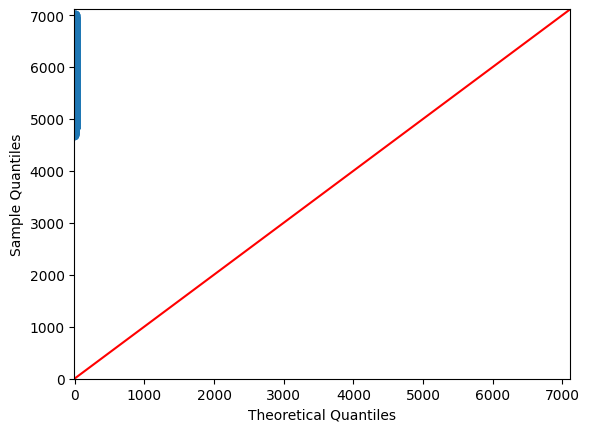

In [ ]:
import statsmodels.api as sm
sm.qqplot(data['Target'], line='45')
plt.show()

In [ ]:
from scipy.stats import normaltest
stat, p = normaltest(data['Target'])
# Interpretation
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')


Sample does not look Gaussian (reject H0)


Apply the Robust Scaler using interquartile range

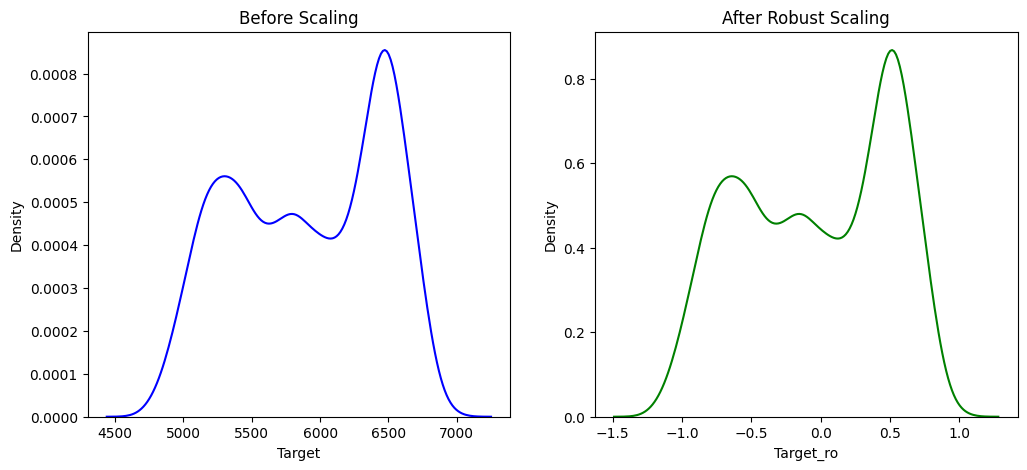

In [ ]:
from sklearn.preprocessing import RobustScaler
import seaborn as sns
# Reshape your data['Target'] to a 2D array
target_reshaped = data['Target'].values.reshape(-1, 1)

# Initialize the RobustScaler
scaler = RobustScaler()

# Fit the RobustScaler to the data
scaler.fit(target_reshaped)

# Transform the data using the fitted scaler
data['Target_ro'] = scaler.transform(target_reshaped)

# Plotting the distributions before and after scaling
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Before Scaling
sns.kdeplot(data['Target'], ax=ax1, color='blue')
ax1.set_title('Before Scaling')

# After Scaling
sns.kdeplot(data['Target_ro'].squeeze(), ax=ax2, color='green')  # .squeeze() changes it from 2D back to 1D for plotting
ax2.set_title('After Robust Scaling')

plt.show()

# Train-test Split

In [ ]:
from sklearn.model_selection import train_test_split

# Define window size or sequence length
sequence_length = 336

# Extract the standardized 'Demand_net' values as a numpy array
demand_net_standardized = data['Target_ro'].values

# Function to create sequences and corresponding labels
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(seq_length, len(data)):
        xs.append(data[i-seq_length:i])
        ys.append(data[i])
    return np.array(xs), np.array(ys)

# Create sequences and labels for the entire dataset
X_all, y_all = create_sequences(demand_net_standardized, sequence_length)

In [ ]:
# First split: 85% for the initial training set, 15% for the temporary set (validation + test)
X_train, X_temp, y_train, y_temp = train_test_split(X_all, y_all, test_size=0.3, random_state=42)

# Second split: Divide the temporary set into validation and test sets (50% each of the temporary set,
# resulting in 15% of the overall data for validation and 15% for testing)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [ ]:
print("Shape of train_X:", X_train.shape)
print("Shape of val_X:", X_val.shape)
print("Shape of test_X:", X_test.shape)

Shape of train_X: (8792, 336)
Shape of val_X: (1884, 336)
Shape of test_X: (1885, 336)


In [ ]:
# Reshape input for LSTM
# This step may not be necessary if 'create_sequences' already returns data in the right shape
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val= X_val.reshape((X_val.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
# Now X_train, y_train are ready for training the LSTM model, and X_test, y_test for evaluation.

In [ ]:
print("Shape of train_X:", X_train.shape)
print("Shape of val_X:", X_val.shape)
print("Shape of test_X:", X_test.shape)

Shape of train_X: (8792, 336, 1)
Shape of val_X: (1884, 336, 1)
Shape of test_X: (1885, 336, 1)


# bi-LSTM

### Tensorflow

bi-LSTM model construction

In [ ]:
import tensorflow as tf

# Assuming X_train.shape[1] is the number of time steps (e.g., 336) and
# X_train.shape[2] is the number of features per time step (e.g., 1)

# Define the bi-LSTM model with 2 bidirectional LSTM layers
model = tf.keras.Sequential([
    # First Bidirectional LSTM layer, returning sequences for the next LSTM layer
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=64, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])),
    # Second Bidirectional LSTM layer
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=64)),
    # Dense layer for output
    tf.keras.layers.Dense(units=1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Summary of the model to check the architecture
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 336, 128)          33792     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               98816     
 onal)                                                           
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 132737 (518.50 KB)
Trainable params: 132737 (518.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Train the model with a specified batch size
batch_size = 32  # Example batch size
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=100, validation_data=(X_val, y_val))


Epoch 1/100
275/275 [==============================] - 24s 57ms/step - loss: 0.0141 - val_loss: 0.0052
Epoch 2/100
275/275 [==============================] - 13s 47ms/step - loss: 0.0044 - val_loss: 0.0032
Epoch 3/100
275/275 [==============================] - 13s 47ms/step - loss: 0.0035 - val_loss: 0.0034
Epoch 4/100
275/275 [==============================] - 13s 47ms/step - loss: 0.0030 - val_loss: 0.0026
Epoch 5/100
275/275 [==============================] - 13s 47ms/step - loss: 0.0026 - val_loss: 0.0023
Epoch 6/100
275/275 [==============================] - 13s 47ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 7/100
275/275 [==============================] - 14s 50ms/step - loss: 0.0022 - val_loss: 0.0017
Epoch 8/100
275/275 [==============================] - 14s 49ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 9/100
275/275 [==============================] - 13s 48ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 10/100
275/275 [==============================] - 13s 47ms/step - l

In [ ]:
# Evaluate the model on the validation set
val_loss = model.evaluate(X_val, y_val)
print(f'Validation Loss: {val_loss}')

# Evaluate the model on the test set
test_loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')


59/59 [==============================] - 1s 22ms/step - loss: 0.0011
Validation Loss: 0.0010615393985062838
59/59 [==============================] - 2s 26ms/step - loss: 0.0011
Test Loss: 0.0010965792462229729


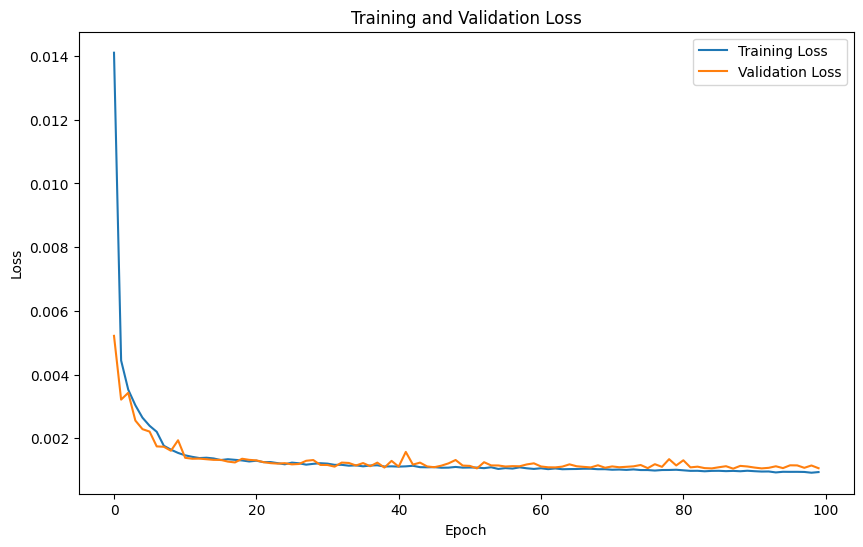

In [ ]:
# prompt: i want to plot the train and validation loss

# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

275/275 [==============================] - 5s 20ms/step
Test MSE: 1129.0153827098577, Test RMSE: 33.600824137360945
Train MSE: 888.793404002175, Train RMSE: 29.812638326759593


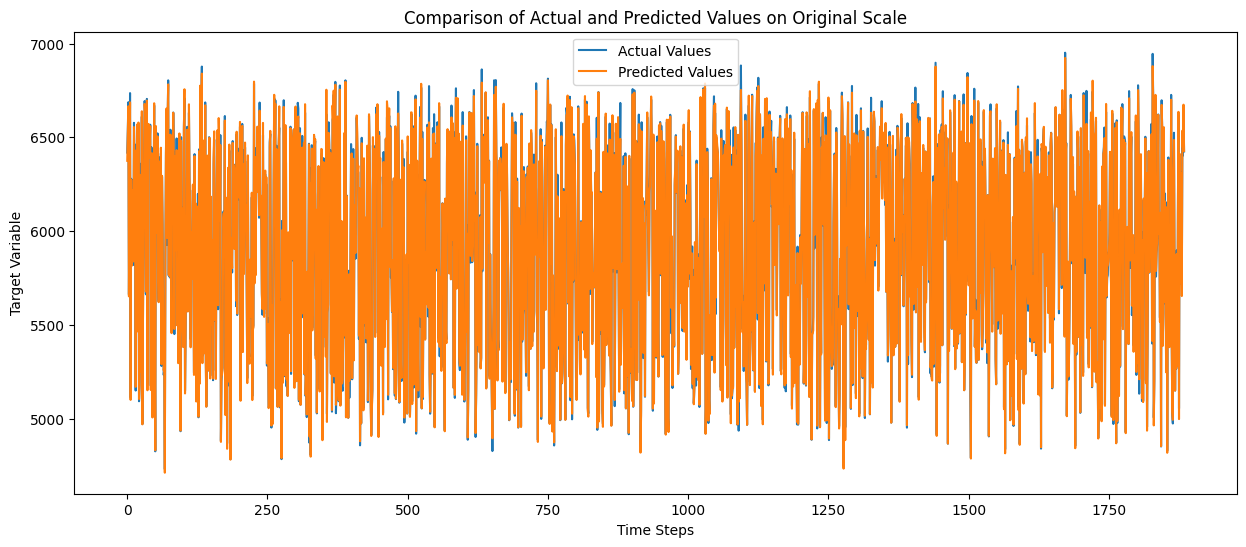

In [ ]:
from sklearn.metrics import mean_squared_error
# Make predictions on the test set using the model
scaled_predictions = model.predict(X_test)

# Inverse transform the predictions and the actual labels
original_predictions = scaler.inverse_transform(scaled_predictions)
original_y_test = scaler.inverse_transform(y_test.reshape(-1, 1))  # Reshape if y_test is a 1D array

# Now 'original_predictions' and 'original_y_test' are in the original data scale

# Calculate the error metrics on the original scale
test_mse = mean_squared_error(original_y_test, original_predictions)
test_rmse = np.sqrt(test_mse)


# Inverse transform the predictions and the actual labels
original_train_predictions = scaler.inverse_transform(model.predict(X_train))
original_y_train = scaler.inverse_transform(y_train.reshape(-1, 1))  # Reshape if y_test is a 1D array

# Now 'original_predictions' and 'original_y_test' are in the original data scale

# Calculate the error metrics on the original scale
train_mse = mean_squared_error(original_y_train, original_train_predictions)
train_rmse = np.sqrt(train_mse)


print(f'Test MSE: {test_mse}, Test RMSE: {test_rmse}')
print(f'Train MSE: {train_mse}, Train RMSE: {train_rmse}')



# Model Output

In [ ]:
import joblib
joblib.dump(scaler, f'robustscaler.pkl')

['robustscaler.pkl']

In [ ]:
# Save the scaler and model
model.save(f'model_bilstm_{timestamp}.h5')
model.save(f'model_bilstm_{timestamp}.keras')